# Standardizing data

Some models, like K-nearest neighbors (KNN) & neural networks, work better with scaled data -- so we'll standardize our data.

In [1]:
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from pandas_datareader import DataReader
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [9,8]

In [2]:
ticker = 'ITSA4.SA'
data_source = 'yahoo'
start = datetime(2016, 1, 1)
end = datetime(2019,12, 31)

itau = DataReader(ticker,data_source, start, end)
itau = itau.sort_values(by='Date')
itau.drop(columns=['High','Low', 'Open', 'Close'], inplace=True)
itau.loc[itau['Volume'] == 0, 'Volume'] = (itau['Volume'].shift(-1) + itau['Volume'].shift(1))/2

In [3]:
# Create 5-day % changes of Adj_Close for the current day, and 5 days in the future
itau['5d_future_close'] = itau['Adj Close'].shift(-5)
itau['5d_close_future_pct'] = itau['5d_future_close'].pct_change(5)
itau['5d_close_pct'] = itau['Adj Close'].pct_change(5)

In [4]:
import talib

feature_names = ['5d_close_pct']  # a list of the feature names for later

# Create moving averages and rsi for timeperiods of 14, 30, 50, and 200
for n in [14,30,50,200]:

    # Create the moving average indicator and divide by Adj_Close
    itau['ma' + str(n)] = talib.SMA(itau['Adj Close'].values,
                              timeperiod=n) / itau['Adj Close']
    # Create the RSI indicator
    itau['rsi' + str(n)] = talib.RSI(itau['Adj Close'].values, timeperiod=n)
    
    # Add rsi and moving average to the feature name list
    feature_names = feature_names + ['ma' + str(n), 'rsi' + str(n)]

In [5]:
# Create 2 new volume features, 1-day % change and 5-day SMA of the % change
new_features = ['Adj_Volume_1d_change', 'Adj_Volume_1d_change_SMA']
feature_names.extend(new_features)
itau['Adj_Volume_1d_change'] = itau['Volume'].pct_change()
itau['Adj_Volume_1d_change_SMA'] = talib.SMA(itau['Adj_Volume_1d_change'].values,
                        timeperiod=5)
itau = itau.dropna()

In [6]:
# Create a size for the training set that is 85% of the total number of samples
features = itau.iloc[:,4:]
targets = itau['5d_close_future_pct']
train_size = int(0.85 * features.shape[0])
train_features = features[:train_size]
train_targets = targets[:train_size]
test_features = features[train_size:]
test_targets = targets[train_size:]

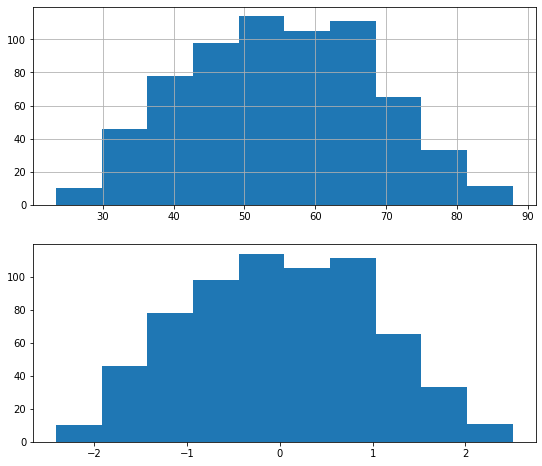

In [7]:
from sklearn.preprocessing import scale

# Standardize the train and test features
scaled_train_features = scale(train_features)
scaled_test_features = scale(test_features)

# Plot histograms of the 14-day SMA RSI before and after scaling
f, ax = plt.subplots(nrows=2, ncols=1)
train_features.iloc[:, 2].hist(ax=ax[0])
ax[1].hist(scaled_train_features[:, 2])
plt.show()

# Optimize n_neighbors

Now that we have scaled data, we can try using a KNN model. To maximize performance, we should tune our model's hyperparameters. 

In [8]:
from sklearn.neighbors import KNeighborsRegressor

for n in range(2,23):
    # Create and fit the KNN model
    knn = KNeighborsRegressor(n_neighbors=n)
    
    # Fit the model to the training data
    knn.fit(scaled_train_features, train_targets)
    
    # Print number of neighbors and the score to find the best value of n
    print("n_neighbors =", n)
    print('train, test scores')
    print(knn.score(scaled_train_features, train_targets))
    print(knn.score(scaled_test_features, test_targets))
    print()  # prints a blank line

n_neighbors = 2
train, test scores
0.7263568783973707
-0.6895403638783411

n_neighbors = 3
train, test scores
0.6072429006243716
-0.6506936839844994

n_neighbors = 4
train, test scores
0.5286824460245365
-0.6042740067646624

n_neighbors = 5
train, test scores
0.47121161898176833
-0.48376781843817573

n_neighbors = 6
train, test scores
0.4428891977704068
-0.44117664403290724

n_neighbors = 7
train, test scores
0.41223414388097224
-0.39912811193277653

n_neighbors = 8
train, test scores
0.3807427540267774
-0.36411211351254225

n_neighbors = 9
train, test scores
0.35626651921350405
-0.32396175465516763

n_neighbors = 10
train, test scores
0.35009028681819077
-0.30391872403365827

n_neighbors = 11
train, test scores
0.3392663859481717
-0.28249856644583504

n_neighbors = 12
train, test scores
0.3154386817491821
-0.26197468987374206

n_neighbors = 13
train, test scores
0.3024224041178276
-0.2625998097556963

n_neighbors = 14
train, test scores
0.2933993572401393
-0.21451694003800603

n_neigh

# Evaluate KNN performance

We just saw a few things with our KNN scores. For one, the training scores started high and decreased with increasing n, which is typical. The test set performance reached a peak at 5 though, and we will use that as our setting in the final KNN model.

0.3154386817491821
-0.26197468987374206


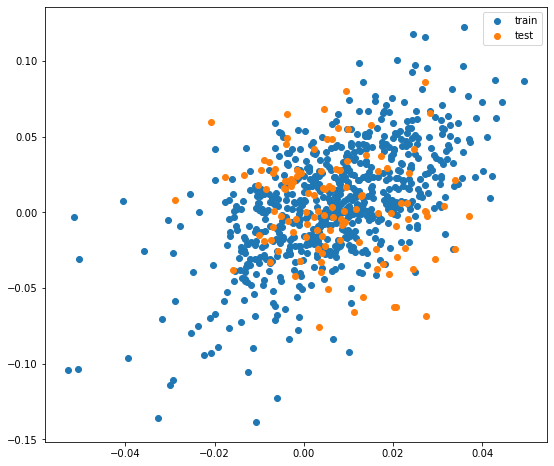

In [9]:
from sklearn.metrics import r2_score

# Create the model with the best-performing n_neighbors of 5
knn = KNeighborsRegressor(n_neighbors=12)

# Fit the model
knn.fit(scaled_train_features, train_targets)

# Get predictions for train and test sets
train_predictions = knn.predict(scaled_train_features)
test_predictions = knn.predict(scaled_test_features)

print(r2_score(train_targets, train_predictions))
print(r2_score(test_targets, test_predictions))

# Plot the actual vs predicted values
plt.scatter(train_predictions, train_targets, label='train')
plt.scatter(test_predictions, test_targets, label='test')
plt.legend()
plt.show()

# Build and fit a simple neural net

The next model we will learn how to use is a neural network. Neural nets can capture complex interactions between variables, but are difficult to set up and understand. Recently, they have been beating human experts in many fields, including image recognition and gaming (check out AlphaGo) -- so they have great potential to perform well.

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [11]:
# Create the model
model_1 = Sequential()
model_1.add(Dense(100, input_dim=scaled_train_features.shape[1], activation='relu'))
model_1.add(Dense(20, activation='relu'))
model_1.add(Dense(1, activation='linear'))

# Fit the model
model_1.compile(optimizer='adam', loss='mse')
history = model_1.fit(scaled_train_features, train_targets, epochs=25)

Epoch 1/25
21/21 [==============================] - 0s 1ms/step - loss: 0.0152
Epoch 2/25
21/21 [==============================] - 0s 903us/step - loss: 0.0058
Epoch 3/25
21/21 [==============================] - 0s 880us/step - loss: 0.0039
Epoch 4/25
21/21 [==============================] - 0s 859us/step - loss: 0.0030
Epoch 5/25
21/21 [==============================] - 0s 2ms/step - loss: 0.0027
Epoch 6/25
21/21 [==============================] - 0s 880us/step - loss: 0.0022
Epoch 7/25
21/21 [==============================] - 0s 801us/step - loss: 0.0020
Epoch 8/25
21/21 [==============================] - 0s 759us/step - loss: 0.0022
Epoch 9/25
21/21 [==============================] - 0s 815us/step - loss: 0.0018
Epoch 10/25
21/21 [==============================] - 0s 782us/step - loss: 0.0016
Epoch 11/25
21/21 [==============================] - 0s 954us/step - loss: 0.0014
Epoch 12/25
21/21 [==============================] - 0s 848us/step - loss: 0.0014
Epoch 13/25
21/21 [==========

# Plot losses

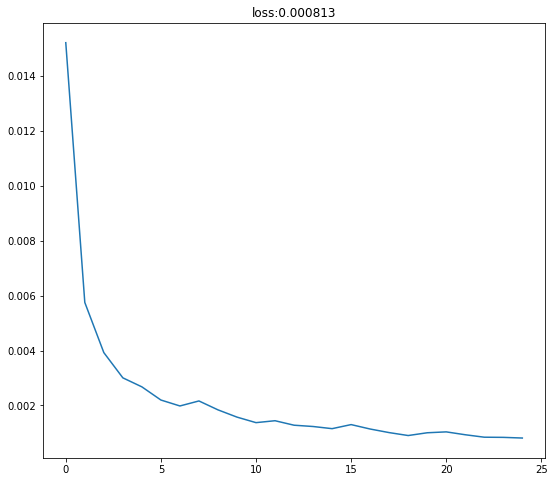

In [12]:
# Plot the losses from the fit
plt.plot(history.history['loss'])

# Use the last loss as the title
plt.title('loss:' + str(round(history.history['loss'][-1], 6)))
plt.show()

# Measure performance

0.504464805773525
-1.2580433526930173


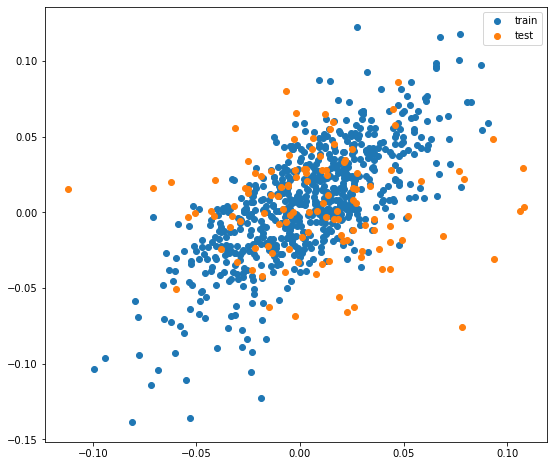

In [13]:
# Calculate R^2 score
train_preds = model_1.predict(scaled_train_features)
test_preds = model_1.predict(scaled_test_features)
print(r2_score(train_targets, train_preds))
print(r2_score(test_targets, test_preds))

# Plot predictions vs actual
plt.scatter(train_preds, train_targets, label='train')
plt.scatter(test_preds, test_targets, label='test')
plt.legend()
plt.show()

# Fit neural net with custom loss function

Now we'll use the custom loss function we just created. This will enable us to alter the model's behavior in useful ways particular to our problem -- it's going to try to force the model to learn how to at least predict price movement direction correctly. 

In [14]:
import tensorflow.keras.losses
import tensorflow as tf

# Create loss function
def sign_penalty(y_true, y_pred):
    penalty = 100.
    loss = tf.where(tf.less(y_true * y_pred, 0), \
                     penalty * tf.square(y_true - y_pred), \
                     tf.square(y_true - y_pred))

    return tf.reduce_mean(loss, axis=-1)

tf.keras.losses.sign_penalty = sign_penalty  # enable use of loss with keras
print(tf.keras.losses.sign_penalty)

<function sign_penalty at 0x7ff96c757b00>


# 

Epoch 1/25
21/21 [==============================] - 0s 878us/step - loss: 0.8815
Epoch 2/25
21/21 [==============================] - 0s 885us/step - loss: 0.3240
Epoch 3/25
21/21 [==============================] - 0s 1ms/step - loss: 0.1771
Epoch 4/25
21/21 [==============================] - 0s 899us/step - loss: 0.1330
Epoch 5/25
21/21 [==============================] - 0s 887us/step - loss: 0.1031
Epoch 6/25
21/21 [==============================] - 0s 1ms/step - loss: 0.0906
Epoch 7/25
21/21 [==============================] - 0s 886us/step - loss: 0.0886
Epoch 8/25
21/21 [==============================] - 0s 813us/step - loss: 0.0679
Epoch 9/25
21/21 [==============================] - 0s 1ms/step - loss: 0.0766
Epoch 10/25
21/21 [==============================] - 0s 895us/step - loss: 0.0630
Epoch 11/25
21/21 [==============================] - 0s 963us/step - loss: 0.0599
Epoch 12/25
21/21 [==============================] - 0s 890us/step - loss: 0.0508
Epoch 13/25
21/21 [============

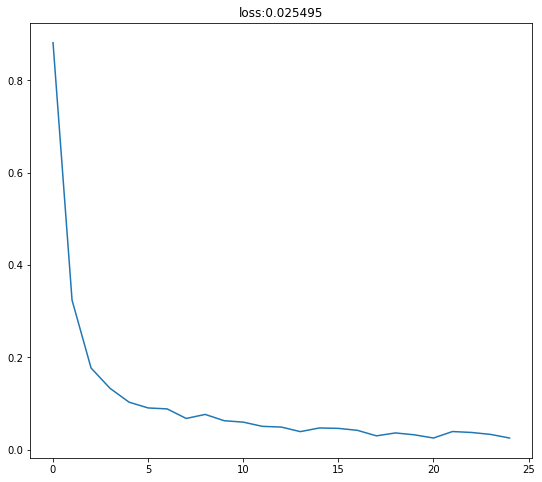

In [15]:
# Create the model
model_2 = Sequential()
model_2.add(Dense(100, input_dim=scaled_train_features.shape[1], activation='relu'))
model_2.add(Dense(20, activation='relu'))
model_2.add(Dense(1, activation='linear'))

# Fit the model with our custom 'sign_penalty' loss function
model_2.compile(optimizer='adam', loss=sign_penalty)
history = model_2.fit(scaled_train_features, train_targets, epochs=25)
plt.plot(history.history['loss'])
plt.title('loss:' + str(round(history.history['loss'][-1], 6)))
plt.show()

0.28793559781920397
-0.8161611925870731


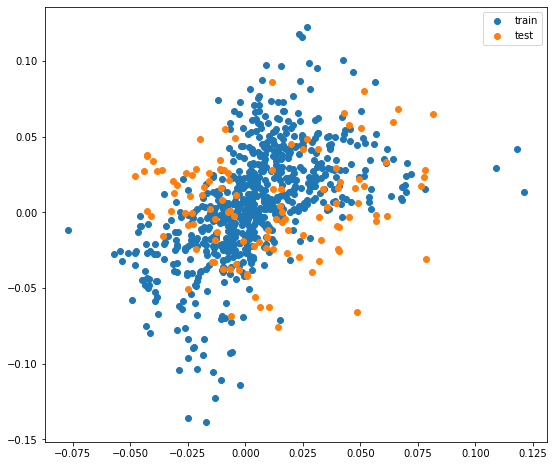

In [16]:
# Evaluate R^2 scores
train_preds = model_2.predict(scaled_train_features)
test_preds = model_2.predict(scaled_test_features)
print(r2_score(train_targets, train_preds))
print(r2_score(test_targets, test_preds))

# Scatter the predictions vs actual -- this one is interesting!
plt.scatter(train_preds, train_targets, label='train')
plt.scatter(test_preds, test_targets, label='test')  # plot test set
plt.legend(); plt.show()

# Combatting overfitting with dropout

A common problem with neural networks is they tend to overfit to training data. What this means is the scoring metric, like R2 or accuracy, is high for the training set, but low for testing and validation sets, and the model is fitting to noise in the training data.

Epoch 1/25
21/21 [==============================] - 0s 861us/step - loss: 0.1637
Epoch 2/25
21/21 [==============================] - 0s 929us/step - loss: 0.0441
Epoch 3/25
21/21 [==============================] - 0s 938us/step - loss: 0.0315
Epoch 4/25
21/21 [==============================] - 0s 864us/step - loss: 0.0277
Epoch 5/25
21/21 [==============================] - 0s 901us/step - loss: 0.0224
Epoch 6/25
21/21 [==============================] - 0s 825us/step - loss: 0.0191
Epoch 7/25
21/21 [==============================] - 0s 858us/step - loss: 0.0143
Epoch 8/25
21/21 [==============================] - 0s 812us/step - loss: 0.0142
Epoch 9/25
21/21 [==============================] - 0s 808us/step - loss: 0.0124
Epoch 10/25
21/21 [==============================] - 0s 856us/step - loss: 0.0114
Epoch 11/25
21/21 [==============================] - 0s 850us/step - loss: 0.0097
Epoch 12/25
21/21 [==============================] - 0s 834us/step - loss: 0.0092
Epoch 13/25
21/21 [======

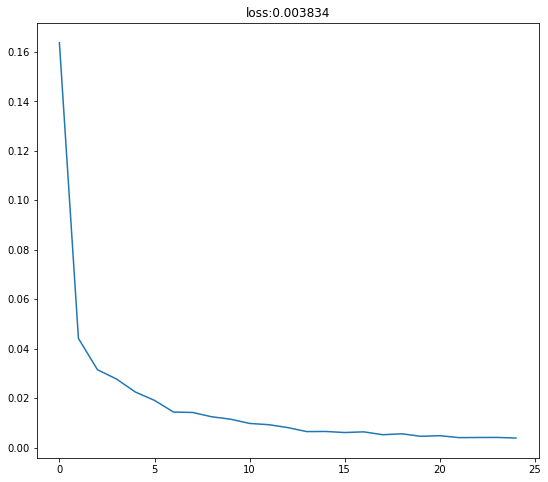

In [17]:
from tensorflow.keras.layers import Dropout

# Create model with dropout
model_3 = Sequential()
model_3.add(Dense(100, input_dim=scaled_train_features.shape[1], activation='relu'))
model_3.add(Dropout(0.2))
model_3.add(Dense(20, activation='relu'))
model_3.add(Dense(1, activation='linear'))

# Fit model with mean squared error loss function
model_3.compile(optimizer='adam', loss='mse')
history = model_3.fit(scaled_train_features, train_targets, epochs=25)
plt.plot(history.history['loss'])
plt.title('loss:' + str(round(history.history['loss'][-1], 6)))
plt.show()

# Ensembling models

One approach to improve predictions from machine learning models is ensembling. A basic approach is to average the predictions from multiple models. A more complex approach is to feed predictions of models into another model, which makes final predictions. Both approaches usually improve our overall performance (as long as our individual models are good). If you remember, random forests are also using ensembling of many decision trees.

In [18]:
# Make predictions from the 3 neural net models
train_pred1 = model_1.predict(scaled_train_features)
test_pred1 = model_1.predict(scaled_test_features)

train_pred2 = model_2.predict(scaled_train_features)
test_pred2 = model_2.predict(scaled_test_features)

train_pred3 = model_3.predict(scaled_train_features)
test_pred3 = model_3.predict(scaled_test_features)

# Horizontally stack predictions and take the average across rows
train_preds = np.mean(np.hstack((train_pred1, train_pred2, train_pred3)), axis=1)
test_preds = np.mean(np.hstack((test_pred1, test_pred2, test_pred3)), axis=1)
print(test_preds[-5:])

[-0.0140003  -0.00340108 -0.01185289 -0.02137588 -0.00650964]


# See how the ensemble performed

Let's check performance of our ensembled model to see how it's doing. We should see roughly an average of the R² scores, as well as a scatter plot that is a mix of our previous models' predictions. The bow-tie shape from the custom loss function model should still be a bit visible, but the edges near x=0 should be softer.

0.4534636201185629
-0.3990803967421399


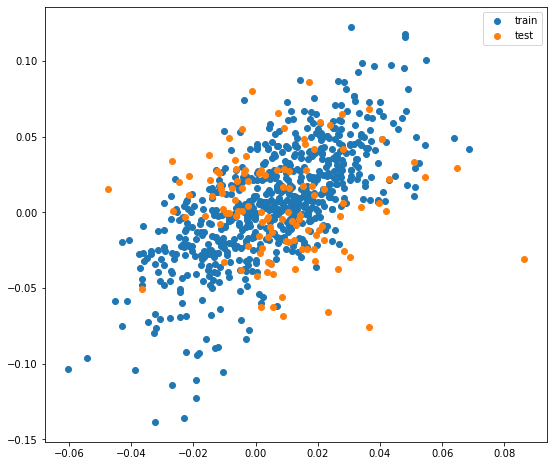

In [19]:
from sklearn.metrics import r2_score

# Evaluate the R^2 scores
print(r2_score(train_targets, train_preds))
print(r2_score(test_targets, test_preds))

# Scatter the predictions vs actual -- this one is interesting!
plt.scatter(train_preds, train_targets, label='train')
plt.scatter(test_preds, test_targets, label='test')
plt.legend(); plt.show()